# Plot

aujust@mail.ustc.edu.cn

In [1]:
from astrorapid.custom_classifier import create_custom_classifier
import astrorapid
from astrorapid import Classify
import numpy as np
import sys
sys.path.append('/home/Aujust/data/Kilonova/Constraint/')
sys.path.append('/home/Aujust/data/Kilonova/GPR/')
import toolkit as tkk
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_custom_data(class_num, data_dir, save_dir, passbands, known_redshift, nprocesses, redo, calculate_t0):
    'class_num: 1-KN, 2-Other'
    name_map = {
        1:['KN_POSSIS','KN_MOSFiT'],
        2:['SNIa','SNIbc','SNIIn','SNIIP','SNIa_91bg','SLSN']
    }

    out = {}
    
    fns = name_map[class_num]
    for fn in fns:
        f_dir = data_dir + fn + '_raw.pkl'
        with open(f_dir,'rb') as handle:
            data = pickle.load(handle)
            handle.close()
            out.update(data)
    
    # if save_dir:
    #     with open(save_dir,'wb') as handle:
    #         pickle.dump(out,handle)
    #         handle.close()

    return out

In [3]:
#For different contexctual info of the model, modify classify.py 
class_nums = (1,2,)
data_raw = {}
for class_num in class_nums:
    out = get_custom_data(class_num,'/home/Aujust/data/Kilonova/KN_classify/data/Training_set_0908/',0,0,0,0,0,0)
    data_raw.update(out)


#Load three classifier
model_contex = [['distmu','distsigma'],['distmu','log_prob'],['distmu','distsigma','log_prob']]
model_dirs = ['/home/Aujust/data/Kilonova/KN_classify/figures1012_no_prob_ks32_drop01/keras_model.hdf5',
    '/home/Aujust/data/Kilonova/KN_classify/figures1012_no_distsigma_ks32_drop01/keras_model.hdf5',
    '/home/Aujust/data/Kilonova/KN_classify/figures1012_ks32_drop01/keras_model.hdf5']
model_names_short = ['MD','PM','PMD'] # P: Probability, M: disatance Mean, D: standard Deviation

classifiers = []
for i in range(len(model_dirs)):
    print(model_contex[i])
    classifier = Classify(model_filepath=model_dirs[i],
                      known_redshift=False,passbands=('g','r','i'),
                      class_names=('Kilonova','Other'),mintime=-2,maxtime=5,timestep=0.5,zcut=False,
                      contextual_info=model_contex[i])
    classifiers.append(classifier)

['distmu', 'distsigma']
/home/Aujust/data/Kilonova/KN_classify/figures1012_no_prob_ks32_drop01/keras_model.hdf5
['distmu', 'log_prob']
/home/Aujust/data/Kilonova/KN_classify/figures1012_no_distsigma_ks32_drop01/keras_model.hdf5
['distmu', 'distsigma', 'log_prob']
/home/Aujust/data/Kilonova/KN_classify/figures1012_ks32_drop01/keras_model.hdf5


In [11]:
from tqdm import tqdm
keys = list(data_raw.keys())
n_samples = len(keys)
training_raw_index = np.random.choice(keys,int(0.15*n_samples))
lc_list = []
metas = []
y_true = []

mwebv = 0.1
ra,dec = -2,-5.3
with tqdm(total=len(training_raw_index)) as pbar:
    for objid in training_raw_index:
        info = data_raw[objid]
        
        mjd = list(info['time'])
        flux = list(info['flux'])
        fluxerr = list(info['fluxErr'])
        passband = info['passband']
        passband = [item[-1] for item in passband]
        photflag = list(info['photflag'])
        redshift = info.meta['redshift']
        
        info_i = (mjd, flux, fluxerr, passband, photflag, ra, dec, objid, redshift, mwebv)
        lc_list.append(info_i)
        meta = info.meta
        y_true.append(meta['class_num'])
        metas.append(meta)
        
        pbar.update(1)

 11%|█         | 1293/11550 [00:00<00:00, 12923.88it/s]

100%|██████████| 11550/11550 [00:04<00:00, 2668.82it/s]


In [12]:
results = []

for i in range(len(model_dirs)):
    predictions,time_steps,objids = classifiers[i].get_predictions(lc_list,other_meta_data=metas,return_predictions_at_obstime=False,return_objids=True)
    results.append((predictions,time_steps,objids))

Preparing light curve 0 of 10718
Preparing light curve 1 of 10718
No data for passband:  r
Preparing light curve 2 of 10718
Preparing light curve 3 of 10718
No data for passband:  r
Preparing light curve 4 of 10718
No data for passband:  r
Preparing light curve 5 of 10718
Preparing light curve 6 of 10718
No data for passband:  g
Preparing light curve 7 of 10718
No data for passband:  g
Preparing light curve 8 of 10718
Preparing light curve 9 of 10718
Preparing light curve 10 of 10718
Preparing light curve 11 of 10718
No data for passband:  r
Preparing light curve 12 of 10718
No data for passband:  g
Preparing light curve 13 of 10718
Preparing light curve 14 of 10718
Preparing light curve 15 of 10718
Preparing light curve 16 of 10718
No data for passband:  r
Preparing light curve 17 of 10718
No data for passband:  g
Preparing light curve 18 of 10718
No data for passband:  r
Preparing light curve 19 of 10718
No data for passband:  g
Preparing light curve 20 of 10718
Preparing light curve

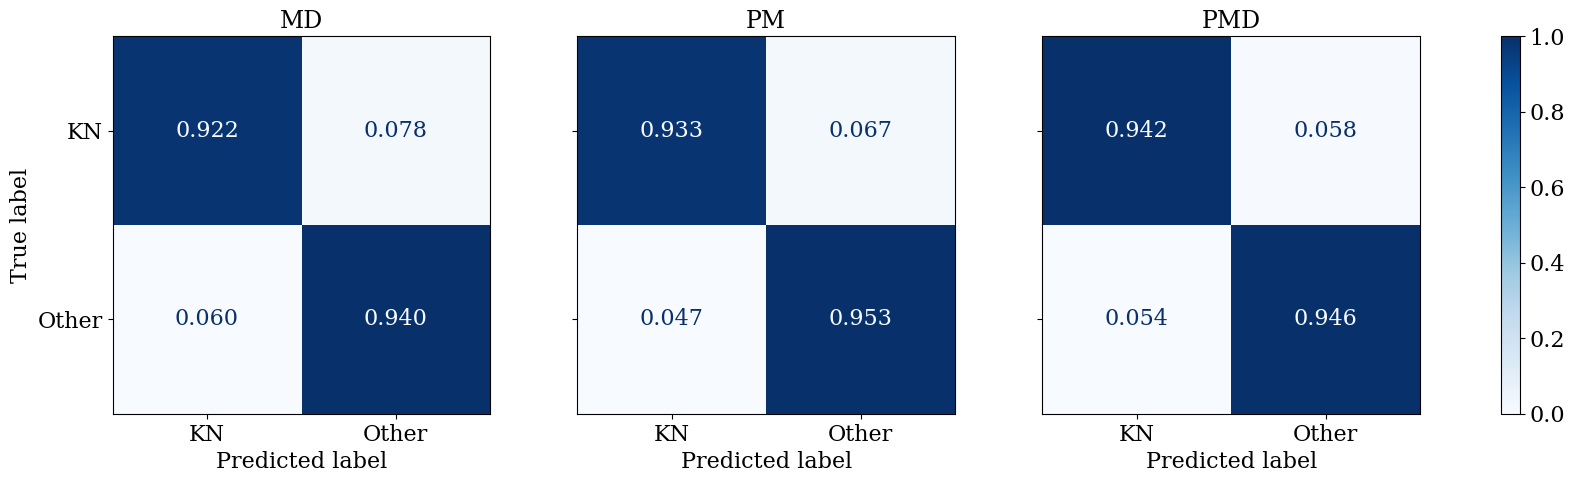

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
fig,ax = plt.subplots(1,3,figsize=(17,5),sharey=True,dpi=100)
norm = matplotlib.colors.Normalize(0,1)
cmap = cm.ScalarMappable(norm=norm, cmap='Blues')
fig.subplots_adjust(wspace=0.05,left=0.05,right=1)
model_contex_math = [r'$\mu_{D},\ \sigma_{D}$',r'$logP_{\rm l.o.s},\ \mu_{D}$',r'$logP_{\rm l.o.s},\ \mu_{D},\ \sigma_{D}$']

for i in range(len(model_dirs)):
    predictions,time_steps,objids = results[i]
    y_predictions = [1 if item[-1,0]>0.45 else 2 for item in predictions]
    y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
    ConfusionMatrixDisplay.from_predictions(y_trues, y_predictions,normalize='true',display_labels=['KN','Other'],cmap='Blues',values_format='.3f',ax=ax[i],colorbar=False)
    ax[i].set_title(model_names_short[i],fontsize=17)
    if i > 0:
        ax[i].set_ylabel('')
    
plt.colorbar(cmap,ax=ax,anchor=(0,0.3),fraction=0.1)
plt.savefig('./figures/three_model_cf.pdf',dpi=300)

## ROC Curve

In [81]:
n = np.linspace(50,300,1000)
P = 1.3383 * n**(-0.096)
p_idx = np.argmax(P<0.8)
n[p_idx]

212.91291291291293

MD Model:
 Precision: 92.885; Recall: 92.597, NPV: 92.620, FNR: 92.907
 
PM Model:
 Precision: 94.733; Recall: 93.673, NPV: 93.743, FNR: 94.792
 
PMD Model:
 Precision: 94.519; Recall: 94.175, NPV: 94.196, FNR: 94.539
 


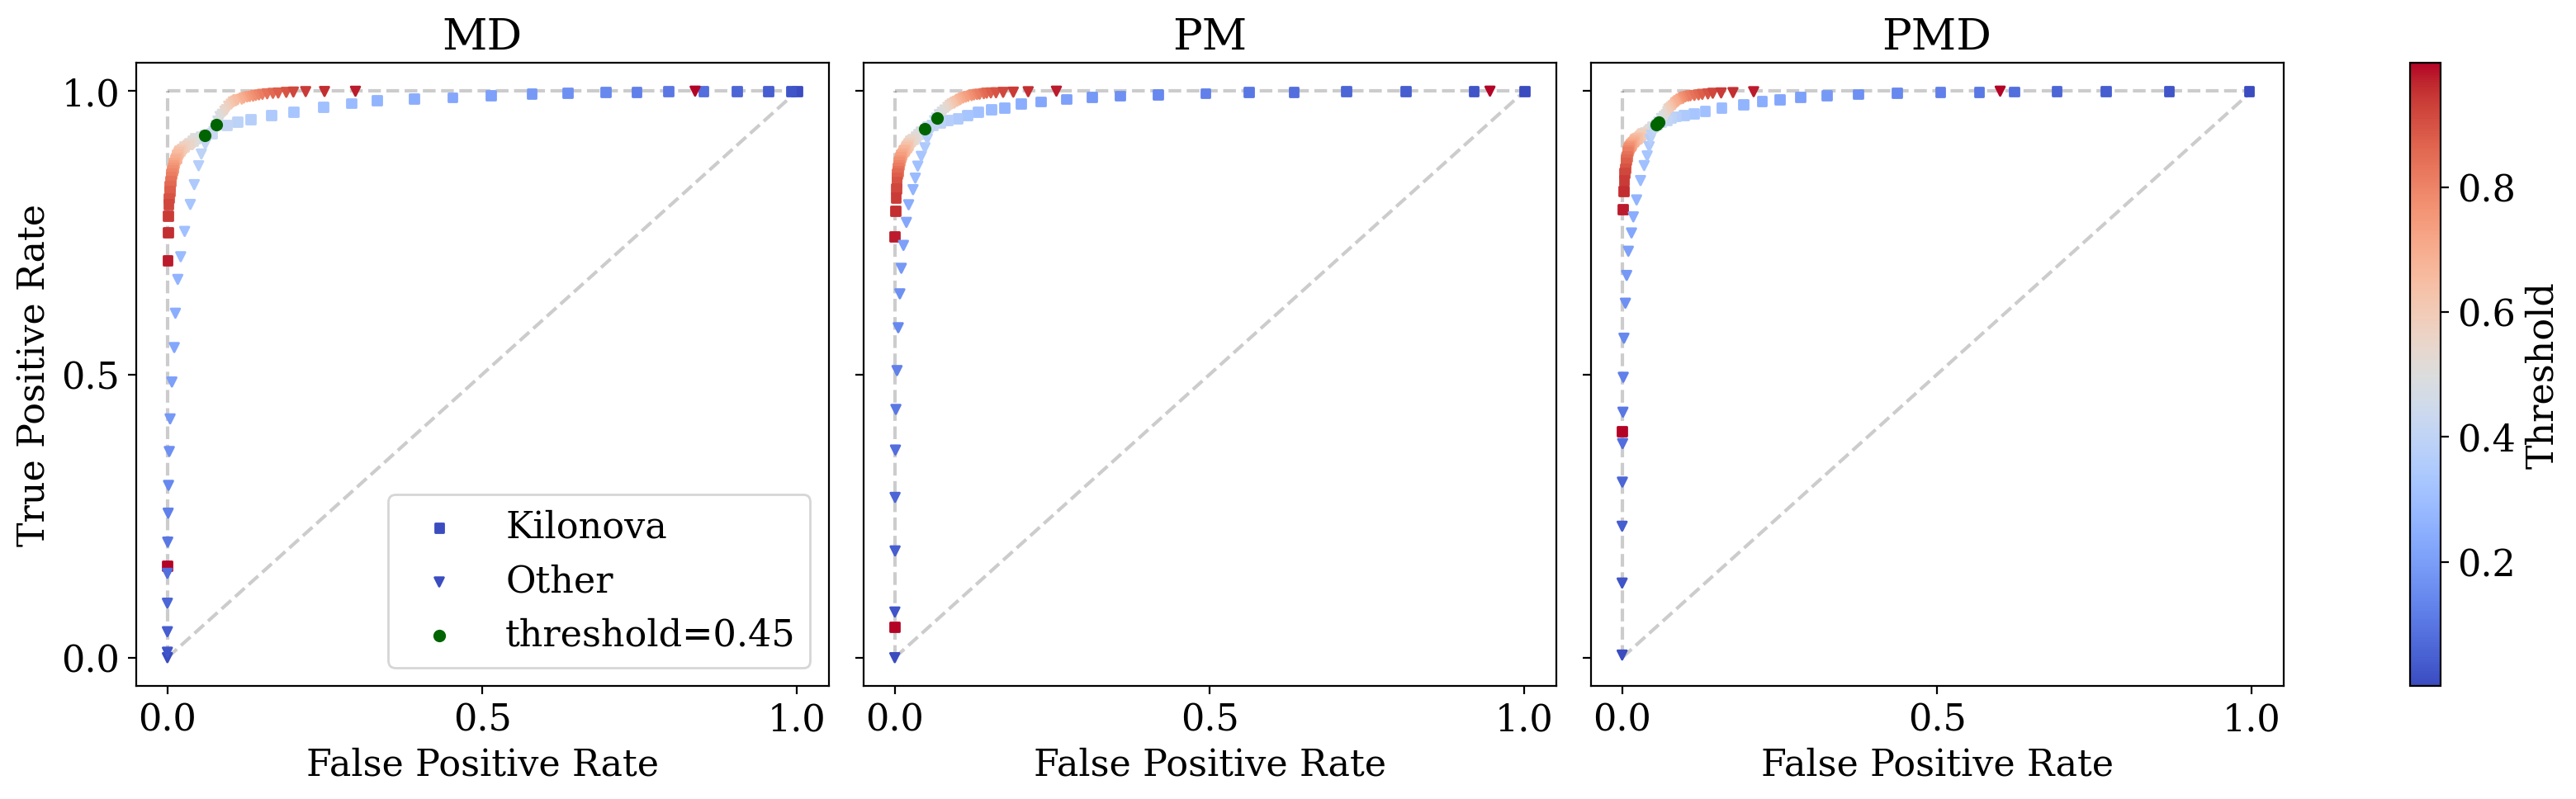

In [74]:
'ROC curve'
from sklearn.metrics import confusion_matrix

THRESHOLDS = np.linspace(0.001,0.999,50)
ROC = []
DEFAULTS = []
WEIGHT_ACC = [] # KN:10, Other:1
weights = (2.5,1)

for i in range(len(model_dirs)):
    'KN'
    TP = []
    FP = []
    'Other'
    TP2 = []
    FP2 = []
    weighted_accs = []

    for threshold in THRESHOLDS:
        predictions,time_steps,objids = results[i]
        y_predictions = [1 if item[-1,0]>threshold else 2 for item in predictions]
        y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
        cf = confusion_matrix(y_trues,y_predictions,normalize='true')
        cf_origin = confusion_matrix(y_trues,y_predictions)
        TP.append(cf[0,0])
        FP.append(cf[1,0])
        TP2.append(cf[1,1])
        FP2.append(cf[0,1])
        weighted_acc = (weights[0]*cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
        weighted_accs.append(weighted_acc)
        
    test_line = np.array(TP) - np.array(TP2)
    arg_index = np.argmax(test_line<0)
    thr = THRESHOLDS[arg_index]
    y_predictions = [1 if item[-1,0]>thr else 2 for item in predictions]
    y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
    cf = confusion_matrix(y_trues,y_predictions,normalize='true')
    default_x = [cf[1,0],cf[0,1]]
    default_y = [cf[0,0],cf[1,1]]
    
    precision = cf[0,0]/(cf[0,0]+cf[1,0])
    recall = cf[0,0]/(cf[0,0]+cf[0,1])
    npv = cf[1,1]/(cf[1,1]+cf[0,1])
    fnr = cf[1,1]/(cf[1,1]+cf[1,0])
    print('{} Model:\n Precision: {:.3f}; Recall: {:.3f}, NPV: {:.3f}, FNR: {:.3f}\n '.format(model_names_short[i],1e2*precision,1e2*recall,1e2*npv,1e2*fnr))

    'default'
    default_thres = 0.45
    #default_thres = thr
    y_predictions = [1 if item[-1,0]>default_thres else 2 for item in predictions]
    y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
    cf = confusion_matrix(y_trues,y_predictions,normalize='true')
    default_x = [cf[1,0],cf[0,1]]
    default_y = [cf[0,0],cf[1,1]]
    
    ROC.append((TP,FP,TP2,FP2))
    DEFAULTS.append((default_x,default_y))
    WEIGHT_ACC.append(weighted_accs)
    

fig,ax = plt.subplots(1,3,figsize=(17,5),sharey=True,dpi=200)
plt.rcParams["font.family"] = 'serif'
fig.subplots_adjust(wspace=0.05,left=0.1,right=1)
plt.rcParams['font.size'] = 16

x_ = np.linspace(0,1,50)
for i in range(len(model_dirs)):
    TP,FP,TP2,FP2 = ROC[i]
    TP,FP,TP2,FP2 = np.array(TP),np.array(FP),np.array(TP2),np.array(FP2)
    default_x,default_y = DEFAULTS[i]
    
    im = ax[i].scatter(FP,TP,c=THRESHOLDS,marker='s',s=15,cmap='coolwarm',label='Kilonova',zorder=1)
    im = ax[i].scatter(FP2,TP2,c=THRESHOLDS,marker='v',s=15,cmap='coolwarm',label='Other',zorder=1)
    ax[i].scatter(default_x,default_y,s=20,c='darkgreen',label='threshold={}'.format(default_thres),zorder=10)
    ax[i].vlines(0,0,1,linestyle='--',color='k',alpha=0.2,zorder=0)
    ax[i].hlines(1,0,1,linestyle='--',color='k',alpha=0.2,zorder=0)
    ax[i].set_xlabel('False Positive Rate')
    ax[i].plot(x_,x_,color='k',linestyle='--',alpha=0.2,zorder=0)
    if i == 0:
        ax[i].set_ylabel('True Positive Rate')
        ax[i].legend()
    ax[i].set_title(model_names_short[i])
    ax[i].set_xticks([0,0.5,1])
    ax[i].set_yticks([0,0.5,1])

cbar = plt.colorbar(im,ax=ax,fraction=0.1)
cbar.set_label('Threshold')
plt.savefig('./figures/roc_curve.pdf',dpi=300)

threshold=0.4083469387755102
threshold=0.4083469387755102
threshold=0.3879795918367347


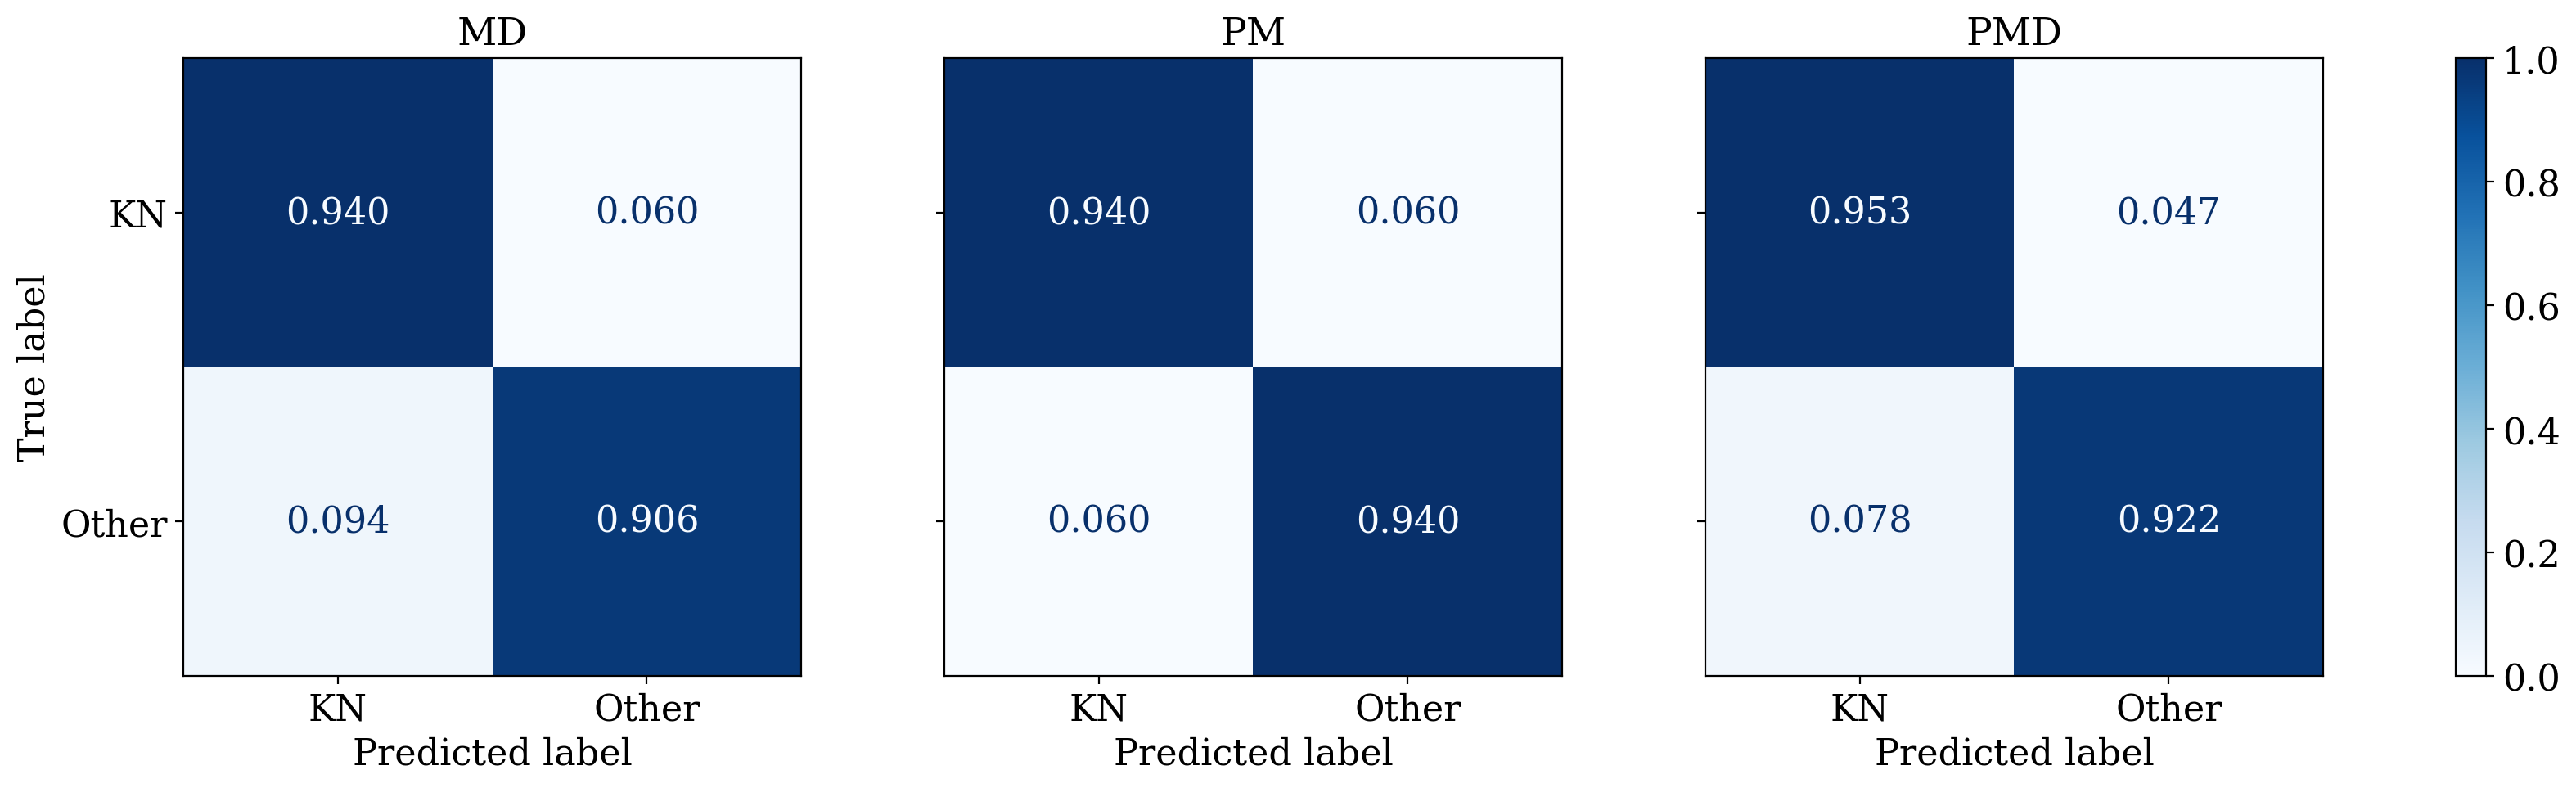

In [75]:
fig,ax = plt.subplots(1,3,figsize=(17,5),sharey=True,dpi=200)
plt.rcParams["font.family"] = 'serif'
fig.subplots_adjust(wspace=0.05,left=0.05,right=1)
plt.rcParams['font.size'] = 16

x_ = np.linspace(0,1,len(weighted_accs))
for i in range(3):
    acc = np.array(WEIGHT_ACC[i])
    #ax[i].plot(x_,acc)
    arg = acc.argmax()
    print('threshold={}'.format(THRESHOLDS[arg]))

    'best'
    predictions,time_steps,objids = results[i]
    y_predictions = [1 if item[-1,0]>THRESHOLDS[arg] else 2 for item in predictions]
    y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
    ConfusionMatrixDisplay.from_predictions(y_trues, y_predictions,normalize='true',display_labels=['KN','Other'],cmap='Blues',values_format='.3f',ax=ax[i],colorbar=False)
    ax[i].set_title(model_names_short[i],fontsize=17)
    if i > 0:
        ax[i].set_ylabel('')
    
plt.colorbar(cmap,ax=ax,anchor=(0,0.3),fraction=0.1)
plt.savefig('./figures/three_model_ef_optimize.pdf')

# Test on Mock Survey

In [13]:
model_names_short = ['MD','PM','PMD'] # P: Probability, M: disatance Mean, D: standard Deviation
def get_all_event_ids(objids):
    out = []
    for objid in objids:
        l = objid.split('_')
        out.append(l[1])
    return np.unique(out)


all_event_ids_full = get_all_event_ids(keys)
#all_event_ids = get_all_event_ids(objids)
#y_trues = [data_raw[objid].meta['class_num'] for objid in objids]

In [14]:
def split_data(trues,predictions,all_event_ids=all_event_ids_full):
    out = {id:{1:[],2:[]} for id in all_event_ids}
    for i, objid in enumerate(objids):
        l = objid.split('_')
        ID = l[1]
        y_true = trues[i]
        kn_prob = predictions[i][-1,0]
        out[ID][y_true].append(kn_prob)
    return out

def ranking_candidates(data,event_id,candidate_nums=21):  #1 KN + 20 SN
    kns = data[event_id][1]
    kn = np.random.choice(kns,1)
    sns = data[event_id][2]
    sns = np.random.choice(sns,candidate_nums-1)
    probs = np.concatenate((kn,sns))  #KN is the last element in the array
    order = (-probs).argsort()
    ranking = order.argsort()
    return ranking[0]+1
        

predictions,time_steps,objids = results[1]
y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
sp_data = split_data(y_trues,predictions)
ranking_candidates(sp_data,'5',50)
#ranking_candidates(sp_data,np.random.choice(all_event_ids_full,1)[0],50)

1

For model MD, SC=10, Fitting parameters a=1.2349, b=0.1067
For model MD, SC=15, Fitting parameters a=1.3491, b=0.1176
For model MD, SC=20, Fitting parameters a=1.4492, b=0.1260
For model PM, SC=10, Fitting parameters a=1.2553, b=0.0932
For model PM, SC=15, Fitting parameters a=1.3249, b=0.0959
For model PM, SC=20, Fitting parameters a=1.3455, b=0.0942
For model PMD, SC=10, Fitting parameters a=1.2172, b=0.0922
For model PMD, SC=15, Fitting parameters a=1.3238, b=0.1013
For model PMD, SC=20, Fitting parameters a=1.4027, b=0.1092


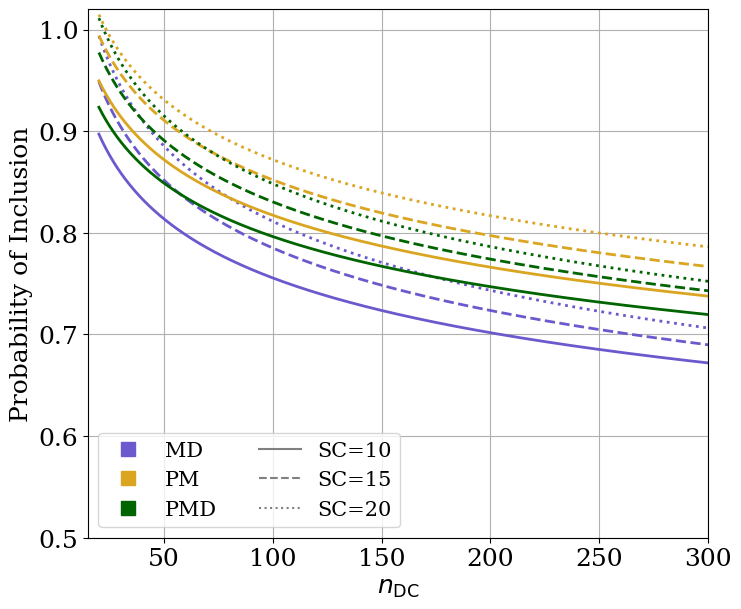

In [26]:
from scipy.optimize import leastsq
from matplotlib.lines import Line2D
plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = 18
fig,ax = plt.subplots(figsize=(8,7),dpi=100)

COLORS = ['slateblue','goldenrod','darkgreen']
LINESTYLES = ['solid','dashed','dotted']

select_cand_list = [10,15,20]
detect_cand_list = np.arange(20,300,5)
aug = 5

for k,classifier in enumerate(classifiers):
    predictions,time_steps,objids = results[k]
    y_trues = [data_raw[objid].meta['class_num'] for objid in objids]
    sp_data = split_data(y_trues,predictions)
    STAT = {sc:0 for sc in select_cand_list}
    for j,select_cand in enumerate(select_cand_list):
        kn_in_select = []
        kn_rank_stat = {}

        dom = len(all_event_ids_full)
        for i,detect_cand in enumerate(detect_cand_list):
            num = np.zeros(aug)
            stat = []
            for event_id in all_event_ids_full:
                for t in range(aug):
                    try:
                        kn_ranking = ranking_candidates(sp_data,event_id,detect_cand)
                        stat.append(kn_ranking)
                        if kn_ranking <= select_cand:
                            num[t] += 1
                        kn_rank_stat[detect_cand] = stat
                    except:
                        continue
            kn_in_select.append(np.mean(num)/dom)
            
        STAT[select_cand] = kn_rank_stat
            
        def err_inclusion(p,x,y):
            return p[0]*x**(-p[1]) - y

        p0 = [1e-2,0.1]
        ret = leastsq(err_inclusion, p0, args = (detect_cand_list,kn_in_select))
        x_ = np.linspace(20,300,500)
        a,b = ret[0]
        print('For model {}, SC={}, Fitting parameters a={:.4f}, b={:.4f}'.format(model_names_short[k],select_cand,a,b))
        # if k == 1:
        #     ax.plot(detect_cand_list,kn_in_select,'+',color=COLORS[k])
        ax.plot(x_,a*x_**(-b),color=COLORS[k],linestyle=LINESTYLES[j],lw=2)
    
handles = [Line2D([],[],color=COLORS[0],marker='s',markersize=10, ls='',label=model_names_short[0]),
           Line2D([],[],color=COLORS[1],marker='s',markersize=10, ls='',label=model_names_short[1]),
           Line2D([],[],color=COLORS[2],marker='s',markersize=10, ls='',label=model_names_short[2]),
           Line2D([],[],color='gray',linestyle=LINESTYLES[0],label='SC=10'),
           Line2D([],[],color='gray',linestyle=LINESTYLES[1],label='SC=15'),
           Line2D([],[],color='gray',linestyle=LINESTYLES[2],label='SC=20')]
#ax.set_xscale('log')
cross_point = 250
ax.grid()
#ax.hlines(0.8,xmin=10,xmax=cross_point,linestyle='dashed',color='k',alpha=0.5)
#ax.vlines(cross_point,ymin=0.5,ymax=0.8,linestyle='dashed',color='k',alpha=0.5)
ax.legend(handles=handles,loc='lower left',ncol=2,fontsize=15)
ax.set_xlim(15,300)
ax.set_ylim(0.5,1.02)
ax.set_ylabel('Probability of Inclusion')
ax.set_xlabel(r'$n_{\rm DC}$')
#ax.text(20,0.52,'Selected Candidates: {}'.format(select_cand),fontsize=13)   
plt.savefig('./figures/three_inclusion_stat_revised.pdf',dpi=300)


## Time Elapse & Sky Coverage

In [4]:
import os
import pandas as pd


survey_dir = '/home/Aujust/data/Kilonova/WFST/ms_event'

def get_coverage(survey_dir,event_id):

    final_dir = '{}/MS_{}/final/'.format(survey_dir,event_id)

    ftest = os.listdir(final_dir)[0]
    index = int(ftest.split('.')[0][-1])

    #summary_dir = '{}/MS_{}/exposure_optimise/test_summary_{}.csv'.format(survey_dir,event_id,index)
    if os.path.exists('{}/MS_{}/exposure_optimise'.format(survey_dir,event_id)):
        summary_dir = '{}/MS_{}/exposure_optimise'.format(survey_dir,event_id)
        sub_dir = 'exposure_optimise'
    else:
        summary_dir = '{}/MS_{}/doRaslice_exposure_optimise'.format(survey_dir,event_id)
        sub_dir = 'doRaslice_exposure_optimise'
        
    flist = os.listdir(summary_dir)
    flist = [item for item in flist if item[:4] == 'test']
    
    dir = '{}/{}'.format(summary_dir,flist[-1])
    f = pd.read_csv(dir)
    return f['obsprob_1'].iloc[0]

get_coverage(survey_dir,90)

0.76461

In [10]:
from test import read_datas, get_basic_ms

event_ids, skymaps, plans, gw_triggers = get_basic_ms('/home/Aujust/data/Kilonova/WFST/ms_event',
                 '/home/Aujust/data/Kilonova/Constraint/Skymaps/bns_astro/bns_skymap',
                 use_plan=True,
                 plan_dir='/home/Aujust/data/Kilonova/Constraint/plans/MS')

t_elapse = []
t_obs = []
coverages = []
survey_dir = '/home/Aujust/data/Kilonova/WFST/ms_event'

for i in range(len(event_ids)):
    event_id = event_ids[i]
    if event_id in all_event_ids_full:
        t_trigger = plans[i].pointings['time'].min()
        t_elapse.append(t_trigger-gw_triggers[i])
        times = plans[i].pointings['time']
        coverage = get_coverage(survey_dir,int(event_id))
        coverages.append(coverage)
        for time in times:
            t_obs.append(time-gw_triggers[i])
    

Pre-processing 555.fits
Pre-processing 332.fits
Pre-processing 361.fits
Pre-processing 101.fits
Pre-processing 302.fits
Pre-processing 792.fits
Pre-processing 761.fits
Pre-processing 994.fits
Pre-processing 509.fits
Pre-processing 640.fits
Pre-processing 846.fits
Pre-processing 270.fits
Pre-processing 883.fits
Pre-processing 5.fits
Pre-processing 882.fits
Pre-processing 285.fits
Pre-processing 90.fits
Pre-processing 238.fits
Pre-processing 863.fits
Pre-processing 403.fits
Pre-processing 631.fits
Pre-processing 201.fits
Pre-processing 665.fits
Pre-processing 239.fits
Pre-processing 91.fits
Pre-processing 980.fits
Pre-processing 179.fits
Pre-processing 942.fits
Pre-processing 124.fits
Pre-processing 579.fits
Pre-processing 745.fits
Pre-processing 928.fits
Pre-processing 319.fits
Pre-processing 533.fits
Pre-processing 195.fits
Pre-processing 132.fits
Pre-processing 755.fits
Pre-processing 309.fits
Pre-processing 955.fits
Pre-processing 798.fits
Pre-processing 901.fits
Pre-processing 306.f

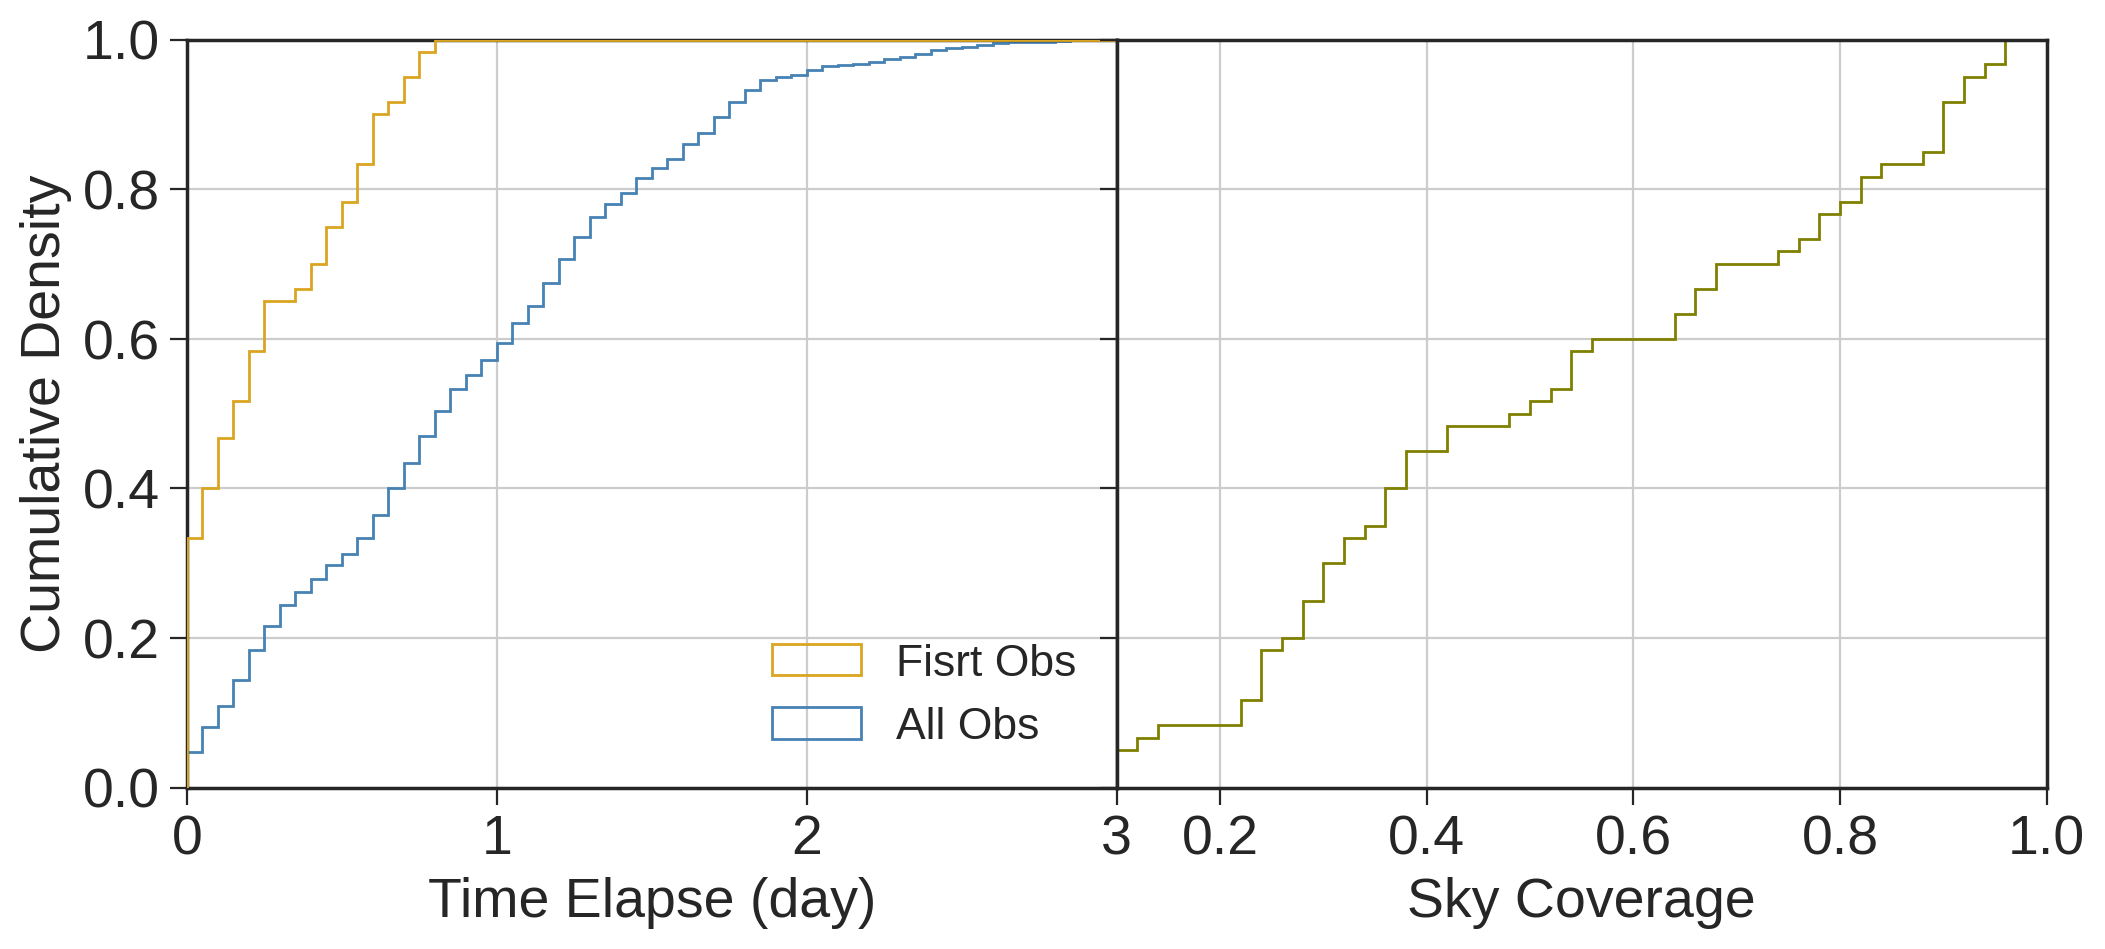

In [12]:
plt.rcParams["font.family"] = 'serif'
plt.rcParams["font.size"] = 20
plt.style.use('seaborn-ticks')
fig,ax = plt.subplots(1,2,figsize=(12,5.5),sharey=True,dpi=200)
fig.subplots_adjust(bottom=0.2,wspace=0.)
bins = 60
weights = np.ones(len(t_elapse))*len(t_obs)/len(t_elapse)
#ax.hist(t_elapse,bins=bins,histtype='stepfilled',color='goldenrod',density=True,weights=weights,alpha=0.2,zorder=10,range=(0,3),cumulative=True)
#ax.hist(t_obs,bins=bins,histtype='stepfilled',color='steelblue',density=True,alpha=0.2,range=(0,3),cumulative=True)
ax[0].hist(t_elapse,bins=bins,histtype='step',color='goldenrod',density=True,weights=weights,zorder=10,range=(0,3),cumulative=True,label='Fisrt Obs')
ax[0].hist(t_obs,bins=bins,histtype='step',color='steelblue',density=True,range=(0,3),cumulative=True,label='All Obs')
ax[0].set_xlabel('Time Elapse (day)')
ax[0].set_ylabel('Cumulative Density')
ax[0].set_xlim([0,3])
ax[0].set_ylim([0,1])
#ax[0].set_yscale('log')
ax[0].grid()
ax[0].legend(fontsize=16,loc='lower right')

ax[1].set_xticks([0.2,0.4,0.6,0.8,1.0])
ax[1].hist(coverages,histtype='step',color='olive',bins=50,range=(0,1),cumulative=True,density=True)
ax[1].grid()
ax[1].set_xlim([0.1,1])
ax[1].set_xlabel('Sky Coverage')

plt.savefig('./figures/t_elapse_coverage_cdf.pdf',dpi=300)